In [1]:
#Final clean

In [2]:
import numpy as np
import pandas as pd
data=pd.read_csv('/Users/empathybroker/Downloads/Data Science Challenge/all journeys/1.csv',header=0,sep=',')

In [3]:
#divide data into chuncks of approx 1000ms each
gps=data[data['type']=='gps']
accel=data[data['type']=='accelerometer']

In [4]:
#index=gps.index
#speeds=gps['speed'].values
xmax=[]
xmin=[]
ymax=[]
ymin=[]
zmax=[]
zmin=[]
for i in range(len(gps)-1):
    a=gps.index[i]+1
    b=gps.index[i+1]
    x=data['x'].iloc[a:b].values  
    try:
        xmax.append(max(x))
    except:
        xmax.append(xmax[i-1])
    try:
        xmin.append(min(x))
    except:
        xmin.append(xmin[i-1])
    y=data['y'].iloc[a:b].values  
    try:
        ymax.append(max(y))
    except:
        ymax.append(ymax[i-1])
    try:
        ymin.append(min(y))
    except:
        ymin.append(ymin[i-1])
    z=data['z'].iloc[a:b].values  
    try:
        zmax.append(max(z))
    except:
        zmax.append(zmax[i-1])
    try:
        zmin.append(min(z))
    except:
        zmin.append(zmin[i-1])
#this will not work if first max value is empty

In [5]:
#convert everything to array to find minmax
xmax=np.asarray(xmax)
ymax=np.asarray(ymax)
zmax=np.asarray(zmax)
xmin=np.asarray(xmin)
ymin=np.asarray(ymin)
zmin=np.asarray(zmin)
xdiff=xmax-xmin
ydiff=ymax-ymin
zdiff=zmax-zmin

In [6]:
#get new variables to check time lapse is about correct, and find difference in speed as new var
gps['timelapse']=gps['timestamp'].shift(-1)-gps['timestamp']
gps['speeddiff']=gps['speed'].shift(-1)-gps['speed']

/Users/empathybroker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/empathybroker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
gps=gps[:-1] #as I dont want the last line due to increases and shift

In [18]:
#New columns are added to be part of training process
gps['xmax']=xmax
gps['xmin']=xmin
gps['xdiff']=xdiff
gps['ymax']=ymax
gps['ymin']=ymin
gps['ydiff']=ydiff
gps['zmax']=zmax
gps['zmin']=zmin
gps['zdiff']=zdiff
#cleaning
del xmax,xmin,xdiff,ymax,ymin,ydiff,zmax,zmin,zdiff

In [9]:
#dropping unwanted columns
gps.drop(['type','lat','lon','height','accuracy','bearing','x','y','z'],axis=1,inplace=True)

In [11]:
#Creating a date from the timestamp
gps['timestamp']=gps['timestamp'].values.astype('datetime64[ms]')

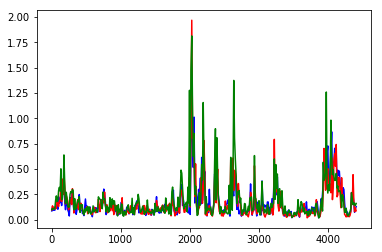

In [14]:
#where do we split the set for labelling?
import matplotlib.pyplot as plt
plt.plot(gps.index,gps['xdiff'],'b')
plt.plot(gps.index,gps['ydiff'],'r')
plt.plot(gps.index,gps['zdiff'],'g')
plt.show()
#We already analysed this set and decided that at iloc[1974] the mobile went from driving to on_foot

In [17]:
#so we label the set accordingly
gpsroad=['fast_road']*len(gps.loc[:1974])
gpsfoot=['on_foot']*len(gps.loc[1975:])
gps['action']=gpsroad+gpsfoot
#cleaning 
del gpsroad,gpsfoot

In [21]:
#prediction time, we test a variety of models to check accuracy
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [23]:
#we don't really need ['timelapse]
gps.drop('timelapse',axis=1,inplace=True)

In [32]:
#We train the set, but keep the timestamp for reference
#now we split into training and test sets
array = gps.values
X = array[:,1:12]
Y = array[:,12]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [33]:
#so, split in 10 parts and train in 9, test in 1
seed = 7
scoring = 'accuracy'

In [34]:
#time to train and check algorithm suitability
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.993750 (0.012500)
LDA: 0.990625 (0.014321)
KNN: 0.993750 (0.012500)
CART: 0.993750 (0.012500)
NB: 0.993750 (0.012500)
SVM: 0.993750 (0.012500)


/Users/empathybroker/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/empathybroker/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/empathybroker/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/empathybroker/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/empathybroker/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/empathybroker/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

In [35]:
#KNeighboursClassifier is best. Let us check on the test set, which has been scrambled
# Make predictions on validation dataset
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[35  0]
 [ 0 45]]
             precision    recall  f1-score   support

  fast_road       1.00      1.00      1.00        35
    on_foot       1.00      1.00      1.00        45

avg / total       1.00      1.00      1.00        80



In [36]:
#Results are quite good, however differences in this training set were quite distinct.

In [37]:
#Let us try against a different dataset 2
data=pd.read_csv('/Users/empathybroker/Downloads/Data Science Challenge/all journeys/2.csv',header=0,sep=',')

In [38]:
gps=data[data['type']=='gps']
accel=data[data['type']=='accelerometer']
xmax=[]
xmin=[]
ymax=[]
ymin=[]
zmax=[]
zmin=[]
for i in range(len(gps)-1):
    a=gps.index[i]+1
    b=gps.index[i+1]
    x=data['x'].iloc[a:b].values  
    try:
        xmax.append(max(x))
    except:
        xmax.append(xmax[i-1])
    try:
        xmin.append(min(x))
    except:
        xmin.append(xmin[i-1])
    y=data['y'].iloc[a:b].values  
    try:
        ymax.append(max(y))
    except:
        ymax.append(ymax[i-1])
    try:
        ymin.append(min(y))
    except:
        ymin.append(ymin[i-1])
    z=data['z'].iloc[a:b].values  
    try:
        zmax.append(max(z))
    except:
        zmax.append(zmax[i-1])
    try:
        zmin.append(min(z))
    except:
        zmin.append(zmin[i-1])
#this will not work if first max value is empty
xmax=np.asarray(xmax)
ymax=np.asarray(ymax)
zmax=np.asarray(zmax)
xmin=np.asarray(xmin)
ymin=np.asarray(ymin)
zmin=np.asarray(zmin)
xdiff=xmax-xmin
ydiff=ymax-ymin
zdiff=zmax-zmin
#get new variables to check time lapse is about correct, and find difference in speed as new var
gps['timelapse']=gps['timestamp'].shift(-1)-gps['timestamp']
gps['speeddiff']=gps['speed'].shift(-1)-gps['speed']
gps=gps[:-1] #as I dont want the last line due to increases and shift
#New columns are added to be part of training process
gps['xmax']=xmax
gps['xmin']=xmin
gps['xdiff']=xdiff
gps['ymax']=ymax
gps['ymin']=ymin
gps['ydiff']=ydiff
gps['zmax']=zmax
gps['zmin']=zmin
gps['zdiff']=zdiff
#cleaning
del xmax,xmin,xdiff,ymax,ymin,ydiff,zmax,zmin,zdiff

/Users/empathybroker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/empathybroker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
#dropping unwanted columns
gps.drop(['type','lat','lon','height','accuracy','bearing','x','y','z'],axis=1,inplace=True)
#Creating a date from the timestamp
gps['timestamp']=gps['timestamp'].values.astype('datetime64[ms]')

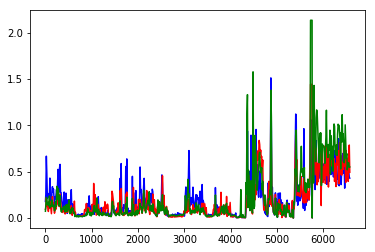

In [40]:
plt.plot(gps.index,gps['xdiff'],'b')
plt.plot(gps.index,gps['ydiff'],'r')
plt.plot(gps.index,gps['zdiff'],'g')
plt.show()

In [50]:
#After observing dataframe, he parks at .loc[4004]
#so we label the set accordingly
gpsroad=['fast_road']*len(gps.loc[:4004])
gpsfoot=['on_foot']*len(gps.loc[4005:])
gps['action']=gpsroad+gpsfoot
#cleaning 
del gpsroad,gpsfoot
#we don't really need ['timelapse]
gps.drop('timelapse',axis=1,inplace=True)

In [51]:
#Using the same system but not training the new set
#now we split into training and test sets
array = gps.values
X = array[:,1:12]
Y = array[:,12]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [52]:
#and now we use the old prediction on the new test
# Make predictions on validation dataset
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.968253968254
[[74  0]
 [ 4 48]]
             precision    recall  f1-score   support

  fast_road       0.95      1.00      0.97        74
    on_foot       1.00      0.92      0.96        52

avg / total       0.97      0.97      0.97       126



In [53]:
#with a prediction of 97% which is not bad. Next we will include more sets and accidents